In [43]:
# =======================
# Textometría – Social/Brandwatch (ES/CO)
# =======================
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk

In [44]:

# --- Descargas NLTK necesarias ---
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)


In [45]:
# ---------- 0) Parámetros ----------
INPUT_FILE = r"C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Inputs\2053806800_Aseguradoras+Query.xlsx"
SHEET_NAME  = None   # None = autodetecta la hoja más grande. O fija: "Sheet0", "Resultados", etc.
LANG_FILTER = {"es", "spa", "spanish"}  # etiquetas de idioma que consideramos español

# Campos a detectar por nombre (insensible a mayúsculas)
CAND_TEXT   = {"text","content","message","body","full_text","fulltext","post","tweet","comment","snippet","title"}
CAND_DATE   = {"date","created_at","createdat","timestamp","time","published","publish_date","publishedat"}
CAND_LANG   = {"lang","language","idioma"}
CAND_SOURCE = {"sitetype","source","sourcetype","platform","site","network","channel"}
CAND_BRAND  = {"brand","empresa","aseguradora","marca","entity","organization"}

# Stopwords en español + dominio (puedes ampliar)
sw_es = set(stopwords.words("spanish"))
sw_dom = {
    # aseguradoras y términos de ruido
   # "sura","seguros","bolívar","bolivar","axa","colpatria","mapfre","allianz","hdi","liberty","positiva","colmena",
   # "metlife","previsora","arl","co","colombia","colombiano","colombiana",
    # social
    "rt","http","https","www","com","10k","15k","5k","carrera"}
STOPWORDS = sw_es | sw_dom


El motivo de poner los nombres de las aseguradoras en sw_dom fue puramente técnico:

Cuando haces conteos de frecuencia (top-20 palabras, Zipf, nube de palabras), si no los quitas, lo que más aparece son justo esas palabras ("sura", "seguros", "bolívar"...).

Eso ensucia la exploración léxica porque lo que quieres ver es qué dice la gente sobre ellas (ej: “demora”, “pago”, “atención”), no repetir “sura sura sura…” como top-1 en todas las gráficas.

En otras palabras: esas palabras funcionan como “stopwords de dominio”. No son irrelevantes para el análisis global (porque sirven para clasificar documentos por marca), pero sí son ruido en la textometría básica.

⚖️ ¿Qué implica esto?

Si tu análisis es comparar percepciones entre aseguradoras, sí conviene filtrar sus nombres en las métricas globales, porque te permite ver los atributos más usados (ej: “demora”, “siniestro”, “mala atención”).

Si tu análisis es medir visibilidad de marca (qué aseguradora aparece más), no deberías filtrarlos. En ese caso quitas los nombres de sw_dom y los dejas en el conteo.

👉 En resumen:
Los agregué para que el top-20 de palabras no sea solo la lista de aseguradoras, sino que muestre percepciones y atributos.

¿Quieres que te prepare dos salidas paralelas (con y sin filtrado de nombres de aseguradoras) para que compares cuál enfoque sirve mejor para tu proyecto?

In [46]:
# ---------- 1) Carga y auto-detección de columnas ----------
xls = pd.ExcelFile(INPUT_FILE)
sheets = xls.sheet_names

# elegir hoja: la más grande si no se especifica
if SHEET_NAME is None:
    sizes = []
    for sh in sheets:
        try:
            n = len(xls.parse(sh))
        except Exception:
            n = -1
        sizes.append((n, sh))
    SHEET_NAME = max(sizes)[1]  # hoja con más filas

df = xls.parse(SHEET_NAME)
orig_cols = list(df.columns)

In [47]:
def _map_cols(candidates):
    """devuelve el nombre original de columna si hay match insensible a mayúsculas"""
    lower_map = {str(c).lower(): c for c in df.columns}
    found = [lower_map[c] for c in candidates if c in lower_map]
    return found

text_cols   = _map_cols({c.lower() for c in CAND_TEXT})
date_cols   = _map_cols({c.lower() for c in CAND_DATE})
lang_cols   = _map_cols({c.lower() for c in CAND_LANG})
source_cols = _map_cols({c.lower() for c in CAND_SOURCE})
brand_cols  = _map_cols({c.lower() for c in CAND_BRAND})

# Elegimos 1 por tipo (si hay múltiples, se toma el primero)
TEXT_COL   = text_cols[0]   if text_cols else None
DATE_COL   = date_cols[0]   if date_cols else None
LANG_COL   = lang_cols[0]   if lang_cols else None
SOURCE_COL = source_cols[0] if source_cols else None
BRAND_COL  = brand_cols[0]  if brand_cols else None

# Validación mínima
assert TEXT_COL is not None, f"No se encontró columna de texto en {orig_cols}. Agrega el nombre correcto a CAND_TEXT."



In [48]:
# ---------- 2) Normalización de columnas útiles ----------
work = df.copy()

# idioma -> intentar filtrar español si hay columna
if LANG_COL:
    work[LANG_COL] = work[LANG_COL].astype(str).str.lower().str.strip()
    work = work[work[LANG_COL].isin(LANG_FILTER)]

# fechas
if DATE_COL:
    work[DATE_COL] = pd.to_datetime(work[DATE_COL], errors="coerce")

# marca/fuente (si existen)
if BRAND_COL:
    work[BRAND_COL] = work[BRAND_COL].astype(str).str.strip()
if SOURCE_COL:
    work[SOURCE_COL] = work[SOURCE_COL].astype(str).str.strip()

# texto
work[TEXT_COL] = work[TEXT_COL].astype(str)



In [49]:
# ---------- 3) Limpieza básica del texto ----------
url_pat   = re.compile(r"http[s]?://\S+")
mention   = re.compile(r"@\w+")
hashtag   = re.compile(r"#\w+")
multi_sp  = re.compile(r"\s+")

def clean_text(t: str) -> str:
    t = t.lower()
    t = url_pat.sub(" ", t)
    t = mention.sub(" ", t)
    t = hashtag.sub(" ", t)
    t = re.sub(r"[^\wáéíóúñü]+", " ", t, flags=re.UNICODE)  # deja letras/números con acentos
    t = multi_sp.sub(" ", t).strip()
    return t

work["text_clean"] = work[TEXT_COL].map(clean_text)
work = work[work["text_clean"].str.len() > 0]

In [50]:
# ---------- 4) Tokenización y métricas básicas ----------
def tokenize_es(s):
    toks = [w for w in tknzr.tokenize(s) if w.isalnum()]
    return toks

work["tokens_all"] = work["text_clean"].map(tokenize_es)

# Métricas
num_docs = len(work)
total_tokens = int(work["tokens_all"].map(len).sum())
avg_tokens = (total_tokens / num_docs) if num_docs else 0

# top con y sin stopwords
def drop_stop(toks):
    return [w for w in toks if w not in STOPWORDS]

work["tokens_nostop"] = work["tokens_all"].map(drop_stop)

cnt_all = Counter([w for toks in work["tokens_all"] for w in toks])
cnt_nst = Counter([w for toks in work["tokens_nostop"] for w in toks])

top_all = pd.DataFrame(cnt_all.most_common(20), columns=["token","freq"])
top_nst = pd.DataFrame(cnt_nst.most_common(20), columns=["token","freq"])

print("=== MÉTRICAS BÁSICAS ===")
print(f"Documentos (filtrados): {num_docs}")
print(f"Tokens totales:         {total_tokens}")
print(f"Promedio tokens/doc:    {avg_tokens:.2f}")
print("\nTop-20 (con stopwords):")
print(top_all.to_string(index=False))
print("\nTop-20 (sin stopwords):")
print(top_nst.to_string(index=False))

=== MÉTRICAS BÁSICAS ===
Documentos (filtrados): 15465
Tokens totales:         314637
Promedio tokens/doc:    20.35

Top-20 (con stopwords):
  token  freq
     de 20753
     la 11155
     en  9085
      y  8475
     el  7809
      a  6378
    que  5966
   para  4143
    por  4016
    del  3806
    con  3729
  grupo  3676
    los  3542
   sura  3329
    las  2524
     se  2481
     no  2439
     un  2186
seguros  2136
     es  2131

Top-20 (sin stopwords):
     token  freq
     grupo  3676
      sura  3329
   seguros  2136
  colombia  1708
     argos  1289
     salud  1138
 previsora   981
  acciones   741
      2024   695
        si   630
    seguro   621
   mensaje   607
   bolívar   596
  empresas   564
      hola   555
  millones   519
presidente   518
     nueva   508
       eps   507
       así   489


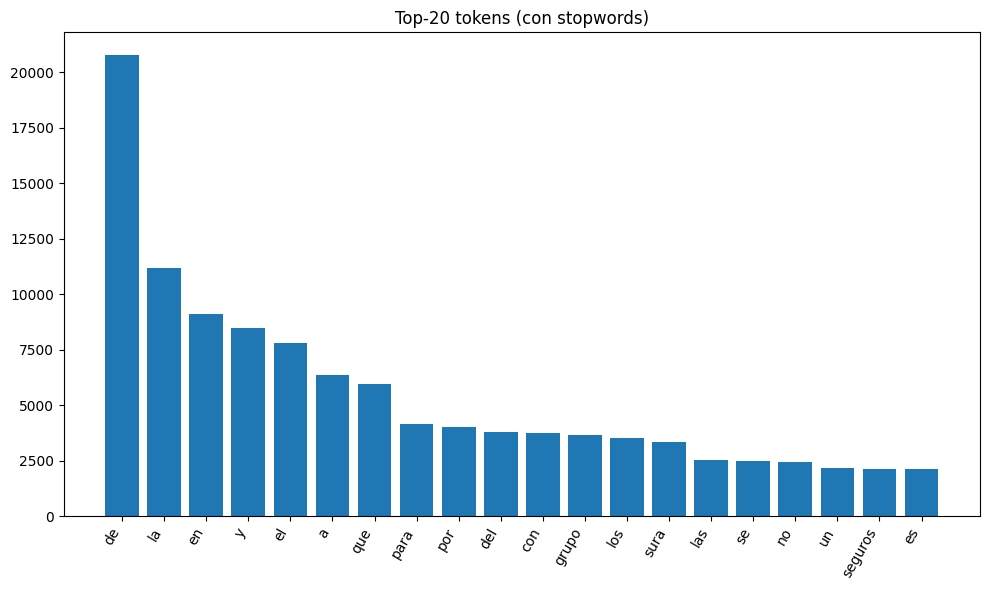

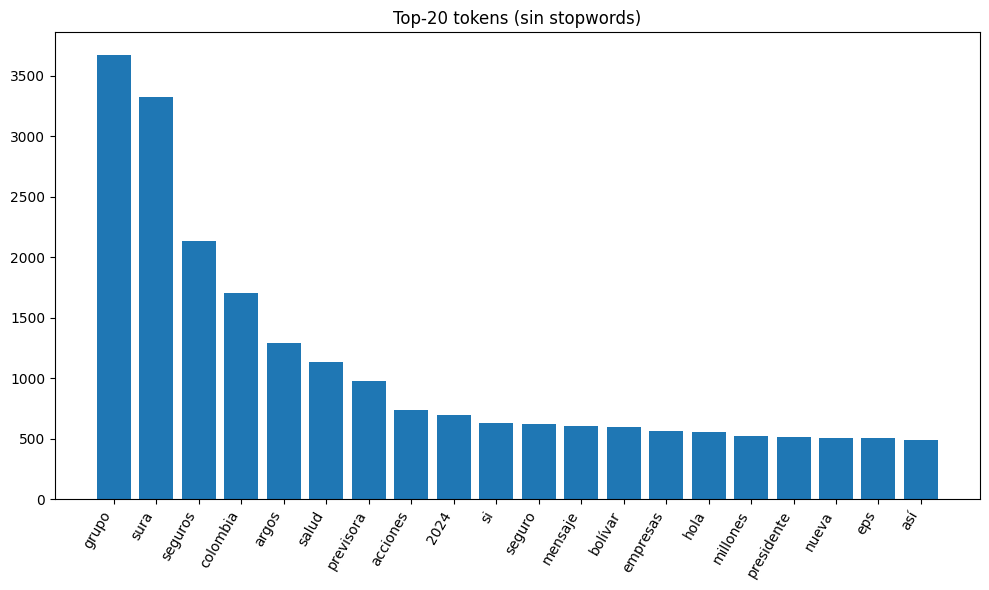

In [51]:
# ---------- 5) Gráficos: barras (top-20) ----------
def plot_bar(df_top, title):
    fig = plt.figure(figsize=(10,6))
    x = np.arange(len(df_top))
    plt.bar(x, df_top["freq"].values)
    plt.xticks(x, df_top["token"].values, rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_bar(top_all, "Top-20 tokens (con stopwords)")
plot_bar(top_nst, "Top-20 tokens (sin stopwords)")

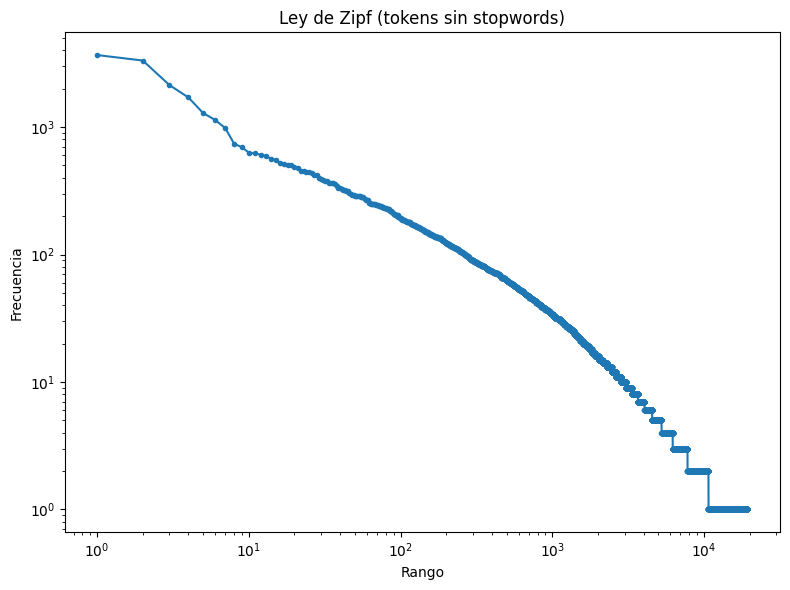

In [52]:
# ---------- 6) Zipf: rank vs frecuencia (log-log) ----------
# construir frecuencia sobre tokens sin stopwords (más informativo)
freq_items = cnt_nst.most_common()
ranks = np.arange(1, len(freq_items)+1)
freqs = np.array([f for _, f in freq_items]) if freq_items else np.array([1.0])

fig = plt.figure(figsize=(8,6))
plt.loglog(ranks, freqs, marker=".")
plt.xlabel("Rango")
plt.ylabel("Frecuencia")
plt.title("Ley de Zipf (tokens sin stopwords)")
plt.tight_layout()
plt.show()

In [53]:
# ---------- 7) Exports ----------
OUT_PREFIX = r"C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Outputs\Outputs_v1"
work_out_cols = [c for c in [DATE_COL, BRAND_COL, SOURCE_COL, TEXT_COL, "text_clean"] if c]
work[work_out_cols].to_csv(f"{OUT_PREFIX}_corpus.csv", index=False)
top_all.to_csv(f"{OUT_PREFIX}_top20_con_stopwords.csv", index=False)
top_nst.to_csv(f"{OUT_PREFIX}_top20_sin_stopwords.csv", index=False)

print("\nArchivos exportados:")
print(f"- Corpus limpio: sandbox:{OUT_PREFIX}_corpus.csv")
print(f"- Top20 con stopwords: sandbox:{OUT_PREFIX}_top20_con_stopwords.csv")
print(f"- Top20 sin stopwords: sandbox:{OUT_PREFIX}_top20_sin_stopwords.csv")

# (Opcional) agregados por marca o por fuente
if BRAND_COL:
    agg_brand = (work
                 .assign(n_tokens=work["tokens_nostop"].map(len))
                 .groupby(BRAND_COL, dropna=False)
                 .agg(docs=(TEXT_COL,"count"), tokens=("n_tokens","sum"))
                 .reset_index())
    agg_brand["tokens/doc"] = agg_brand["tokens"] / agg_brand["docs"]
    print("\nResumen por marca:")
    print(agg_brand.sort_values("docs", ascending=False).head(10).to_string(index=False))
    agg_brand.to_csv(f"{OUT_PREFIX}_resumen_por_marca.csv", index=False)


Archivos exportados:
- Corpus limpio: sandbox:C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Outputs\Outputs_v1_corpus.csv
- Top20 con stopwords: sandbox:C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Outputs\Outputs_v1_top20_con_stopwords.csv
- Top20 sin stopwords: sandbox:C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Outputs\Outputs_v1_top20_sin_stopwords.csv


In [54]:
# for i in df['Title'].unique():
  #  print(i)
  

In [56]:

import os
import re
from collections import Counter, defaultdict
from itertools import tee, islice
import matplotlib.pyplot as plt

# Opcional: nubes de palabras
try:
    from wordcloud import WordCloud
    HAS_WC = True
except Exception:
    HAS_WC = False
    print("[Aviso] 'wordcloud' no está instalado. Se generarán solo barras de n-gramas.")

# ---------- Parámetros ----------
# Carpeta de salida para figuras
OUT_DIR_FIG = os.path.join(os.path.dirname(OUT_PREFIX), "figs_by_brand")
os.makedirs(OUT_DIR_FIG, exist_ok=True)

# Número de marcas a graficar (top por #docs)
TOP_BRANDS_TO_PLOT = 8

# Top-K n-gramas para mostrar
TOPK_NGRAMS = 20

# Si quieres incluir nombres de marca en nubes/n-gramas, pon False
EXCLUIR_MARCAS_EN_VIS = True

# ---------- 8.1 Detección de marca en el texto ----------
# Diccionario de patrones por marca (minúsculas). Agrega/ajusta según tu corpus.
# Incluye variantes, hashtags y frases comunes.
BRAND_PATTERNS = {
    "Sura":        r"\b#?sura\b|@?segurossura\b",
    "Seguros Bolívar": r"\b(bol[ií]var|seguros\s+bol[ií]var)\b|@?segurosbolivar\b|#?segurosbolivar\b",
    "AXA Colpatria":   r"\b(axa\s*colpatria|colpatria|@?axacolpatria|#?axacolpatria)\b",
    "MAPFRE":      r"\bmapfre\b|@?mapfre_\w*|#?mapfre\b",
    "Allianz":     r"\ballianz\b|@?allianzcolombia\b|#?allianz\b",
    "HDI":         r"\bhdi\b|@?hdi\w*\b|#?hdi\b",
    "Liberty":     r"\bliberty\b|@?libertyseguros\w*\b|#?liberty\b",
    "Positiva":    r"\bpositiva\b|@?positivacomp\b|#?positiva\b",
    "Colmena":     r"\bcolmena\b|@?colmenaseguros\b|#?colmena\b",
    "MetLife":     r"\bmetlife\b|@?metlifeco\b|#?metlife\b",
    "La Previsora":r"\b(previsora|la\s+previsora)\b|@?laprevisora_co\b|#?previsora\b",
}

# Compilar regex una vez
BRAND_REGEX = {brand: re.compile(pat, flags=re.IGNORECASE) for brand, pat in BRAND_PATTERNS.items()}

def detect_brand(text: str) -> str:
    """Devuelve la primera marca que haga match. Si hay múltiples, concatena; si ninguna, 'Sin marca'."""
    hits = []
    for brand, rgx in BRAND_REGEX.items():
        if rgx.search(text or ""):
            hits.append(brand)
    if not hits:
        return "Sin marca"
    # Si prefieres la primera coincidencia:
    # return hits[0]
    # O todas separadas por '|':
    return "|".join(sorted(set(hits)))

# Crea columna con la marca detectada sobre el texto limpio
work["brand_detected"] = work["text_clean"].map(detect_brand)

# ---------- 8.2 Preparar tokens para visualización ----------
# Usamos tokens sin stopwords (incluye stopwords de dominio) para resaltar atributos.
# Si quieres incluir los nombres de marca en visualizaciones: usa tokens_sin_dom = tokens_all con stopwords estándar
if EXCLUIR_MARCAS_EN_VIS:
    tokens_for_vis_col = "tokens_nostop"
else:
    # Recrea una columna alternativa sin excluir marcas (solo stopwords ES), si te interesa
    # Aquí: copiamos tokens_all y quitamos solo stopwords generales (no de dominio)
    sw_es_only = sw_es  # viene de tu bloque previo
    def drop_stop_es_only(toks):
        return [w for w in toks if w not in sw_es_only]
    work["tokens_no_domstop"] = work["tokens_all"].map(drop_stop_es_only)
    tokens_for_vis_col = "tokens_no_domstop"

# ---------- 8.3 N-gramas ----------
def ngrams(tokens, n):
    """Genera n-gramas contiguos de tamaño n a partir de una lista de tokens."""
    if not tokens or len(tokens) < n:
        return []
    iters = tee(tokens, n)
    for i, it in enumerate(iters):
        next(islice(it, i, i), None)
    return list(zip(*iters))

def top_ngrams(list_of_token_lists, n=2, topk=20):
    """Cuenta n-gramas sobre una lista de listas de tokens y devuelve top-k como DataFrame."""
    cnt = Counter()
    for toks in list_of_token_lists:
        for ng in ngrams(toks, n):
            cnt[ng] += 1
    df = (pd.DataFrame(cnt.most_common(topk), columns=["ngram","freq"])
            if cnt else pd.DataFrame(columns=["ngram","freq"]))
    # Representación amigable del n-grama
    if len(df):
        df["ngram_text"] = df["ngram"].apply(lambda tup: " ".join(tup))
    return df

# ---------- 8.4 Agregación por marca detectada ----------
# Selecciona top marcas por #docs para graficar
brand_doc_counts = (work.groupby("brand_detected")[TEXT_COL]
                    .count()
                    .sort_values(ascending=False)
                    .rename("docs"))
brands_to_plot = [b for b in brand_doc_counts.index.tolist() if b != "Sin marca"][:TOP_BRANDS_TO_PLOT]

# Guarda tablas CSV con n-gramas por marca
csv_dir = os.path.join(os.path.dirname(OUT_PREFIX), "ngrams_by_brand")
os.makedirs(csv_dir, exist_ok=True)

for brand in brands_to_plot:
    subset = work[work["brand_detected"].str.contains(rf"(?:^|\|){re.escape(brand)}(?:$|\|)", regex=True)]
    token_lists = subset[tokens_for_vis_col].tolist()

    bigrams_df  = top_ngrams(token_lists, n=2, topk=TOPK_NGRAMS)
    trigrams_df = top_ngrams(token_lists, n=3, topk=TOPK_NGRAMS)

    bigrams_df.to_csv(os.path.join(csv_dir, f"{brand}_bigrams.csv"), index=False)
    trigrams_df.to_csv(os.path.join(csv_dir, f"{brand}_trigrams.csv"), index=False)

# ---------- 8.5 Gráficos por marca ----------
def plot_brand_panels(brand, token_lists, out_dir=OUT_DIR_FIG, topk=TOPK_NGRAMS):
    """Crea 2 o 3 paneles por marca: WordCloud (si disponible), Top-20 bigramas, Top-20 trigramas."""
    bigrams_df  = top_ngrams(token_lists, n=2, topk=topk)
    trigrams_df = top_ngrams(token_lists, n=3, topk=topk)

    # Layout dinámico según disponibilidad de WordCloud
    if HAS_WC:
        fig = plt.figure(figsize=(16, 10))
        # Panel 1: WordCloud
        ax1 = plt.subplot2grid((2,3), (0,0), colspan=1, rowspan=2)
        flat_tokens = [t for lst in token_lists for t in lst]
        txt = " ".join(flat_tokens) if flat_tokens else ""
        if txt.strip():
            wc = WordCloud(width=900, height=900, background_color="white").generate(txt)
            ax1.imshow(wc, interpolation="bilinear")
            ax1.axis("off")
            ax1.set_title(f"{brand} – Nube de palabras", fontsize=12)
        else:
            ax1.text(0.5, 0.5, "Sin tokens", ha="center", va="center")
            ax1.axis("off")
            ax1.set_title(f"{brand} – Nube de palabras (vacía)", fontsize=12)

        # Panel 2: Bigramas
        ax2 = plt.subplot2grid((2,3), (0,1), colspan=2, rowspan=1)
        if len(bigrams_df):
            ax2.barh(range(len(bigrams_df))[::-1], bigrams_df["freq"].values[::-1])
            ax2.set_yticks(range(len(bigrams_df))[::-1])
            ax2.set_yticklabels(bigrams_df["ngram_text"].values[::-1])
            ax2.set_title(f"{brand} – Top {topk} Bigramas")
        else:
            ax2.text(0.5, 0.5, "Sin bigramas", ha="center", va="center"); ax2.axis("off")

        # Panel 3: Trigramas
        ax3 = plt.subplot2grid((2,3), (1,1), colspan=2, rowspan=1)
        if len(trigrams_df):
            ax3.barh(range(len(trigrams_df))[::-1], trigrams_df["freq"].values[::-1])
            ax3.set_yticks(range(len(trigrams_df))[::-1])
            ax3.set_yticklabels(trigrams_df["ngram_text"].values[::-1])
            ax3.set_title(f"{brand} – Top {topk} Trigramas")
        else:
            ax3.text(0.5, 0.5, "Sin trigramas", ha="center", va="center"); ax3.axis("off")

        plt.tight_layout()
    else:
        # Sin WordCloud: solo bigramas y trigramas
        fig = plt.figure(figsize=(14, 8))
        ax2 = plt.subplot(2,1,1)
        if len(bigrams_df):
            ax2.barh(range(len(bigrams_df))[::-1], bigrams_df["freq"].values[::-1])
            ax2.set_yticks(range(len(bigrams_df))[::-1])
            ax2.set_yticklabels(bigrams_df["ngram_text"].values[::-1])
            ax2.set_title(f"{brand} – Top {topk} Bigramas")
        else:
            ax2.text(0.5, 0.5, "Sin bigramas", ha="center", va="center"); ax2.axis("off")

        ax3 = plt.subplot(2,1,2)
        if len(trigrams_df):
            ax3.barh(range(len(trigrams_df))[::-1], trigrams_df["freq"].values[::-1])
            ax3.set_yticks(range(len(trigrams_df))[::-1])
            ax3.set_yticklabels(trigrams_df["ngram_text"].values[::-1])
            ax3.set_title(f"{brand} – Top {topk} Trigramas")
        else:
            ax3.text(0.5, 0.5, "Sin trigramas", ha="center", va="center"); ax3.axis("off")

        plt.tight_layout()

    # Guardar figura
    fn = os.path.join(out_dir, f"{brand}_wordcloud_ngrams.png")
    plt.savefig(fn, dpi=160)
    plt.close()
    return fn

generated_figs = []
for brand in brands_to_plot:
    subset = work[work["brand_detected"].str.contains(rf"(?:^|\|){re.escape(brand)}(?:$|\|)", regex=True)]
    token_lists = subset[tokens_for_vis_col].tolist()
    fig_path = plot_brand_panels(brand, token_lists, out_dir=OUT_DIR_FIG, topk=TOPK_NGRAMS)
    generated_figs.append((brand, fig_path))

# ---------- 8.6 Export resumen por marca detectada ----------
resumen_detect = (work
                  .groupby("brand_detected")
                  .agg(docs=(TEXT_COL, "count"))
                  .reset_index()
                  .sort_values("docs", ascending=False))
resumen_detect.to_csv(os.path.join(os.path.dirname(OUT_PREFIX), "resumen_por_brand_detected.csv"), index=False)

print("\n=== Detección de marca y visualizaciones por aseguradora ===")
print("Resumen por marca detectada (top):")
print(resumen_detect.head(15).to_string(index=False))
print(f"\nFiguras guardadas en: {OUT_DIR_FIG}")
for b, p in generated_figs[:10]:
    print(f"- {b}: {p}")

# ---------- 8.7 Tips rápidos ----------
# - Si quieres 'visibilidad de marca', marca EXCLUIR_MARCAS_EN_VIS = False y usa tokens con marca.
# - Amplía BRAND_PATTERNS con más aliases, @handles y hashtags propios de tu dataset.
# - Si muchos tuits mencionan múltiples marcas, podrías:
#     a) quedarte con la primera coincidencia (devuelve hits[0])
#     b) duplicar el registro por marca (explode) antes de contar/visualizar.



=== Detección de marca y visualizaciones por aseguradora ===
Resumen por marca detectada (top):
       brand_detected  docs
            Sin marca  9764
                 Sura  2969
         La Previsora  1014
      Seguros Bolívar   638
               MAPFRE   250
        AXA Colpatria   183
             Positiva   140
              Allianz   138
              Colmena    63
 Seguros Bolívar|Sura    48
          HDI|Liberty    48
              MetLife    45
La Previsora|Positiva    37
                  HDI    30
              Liberty    24

Figuras guardadas en: C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Outputs\figs_by_brand
- Sura: C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Outputs\figs_by_brand\Sura_wordcloud_ngrams.png
- La Previsora: C:\Users\santi\Downloads\Learning\Maestria\Programacion Lenguaje Natural\Proyecto\Outputs\figs_by_brand\La Previsora_wordcloud_ngrams.png
- Seguros Bolívar: C:\Users\santi\Do

In [57]:
# Número total de palabras (tokens) y promedio por documento
total_palabras = work["tokens_all"].map(len).sum()
promedio_palabras = work["tokens_all"].map(len).mean()

print(f"Número total de palabras: {total_palabras}")
print(f"Promedio de palabras por documento: {promedio_palabras:.2f}")


Número total de palabras: 314637
Promedio de palabras por documento: 20.35
